Análisis de performance de agentes - Búsqueda Local
===
# Tiempo de ejecución

In [1]:
import NQueens
import random
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from time import time_ns

## Se llevará a cabo con la siguiente configuración:

In [2]:
algorithms = [NQueens.hill_climbing, NQueens.simulated_annealing, NQueens.genetic_algorithm]
sizes = [4, 8, 10, 12, 15]
n_iterations = 30
iter_limit_pow = 4
random.seed(42)

---

# Tiempo de ejecución

## Correr simulación

In [3]:
def run_simulation(simulations, algorithms, size, limit):
    # Run in each agent
    for algorithm in algorithms:
        # Run agent
        start = time_ns()
        _, best_h, iterations, _ = algorithm(size, limit)
        end = time_ns()
        
        # Append results in the siumlations dict
        simulations.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'best_h': best_h,
            'iterations': iterations,
            'time_ms': (end-start)/1e6
        })

In [4]:
# Using parallelism :D
with mp.Manager() as manager:
    simulations = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Test iterations
    for size in sizes:
        for _ in range(n_iterations):
            pool.apply_async(run_simulation, args=(simulations, algorithms, size, size**iter_limit_pow))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations_df = pd.DataFrame(list(simulations))

simulations_df.to_csv('simulations.csv')
simulations_df

,algorithm,size,best_h,iterations,time_ms
0,hill_climbing,4,2,12,0.272854
1,hill_climbing,4,2,12,0.332946
2,hill_climbing,4,2,12,0.382167
3,hill_climbing,4,0,36,0.805033
4,simulated_annealing,4,0,7,0.228941
...,...,...,...,...,...
445,simulated_annealing,15,0,16458,443.328671
446,simulated_annealing,15,0,2268,69.680644
447,genetic_algorithm,15,2,51000,6642.605833
448,genetic_algorithm,15,2,51000,3413.475894


## Análisis del performance de cada algorítmo

In [5]:
samples_list = []

for algorithm in algorithms:
    for size in sizes:
        sample_df = simulations_df.query(f'algorithm == "{algorithm.__name__}" and size == {size}')
        
        # Find optimals
        try:
            optimals = sample_df.best_h.value_counts().loc[0]
        except KeyError:
            optimals = 0
        
        # Save saple report
        samples_list.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'optimal_rate': optimals / n_iterations,
            'h_reached_avg': sample_df['best_h'].mean(),
            'h_reached_std': sample_df['best_h'].std(),
            'time_ms_avg': sample_df['time_ms'].mean(),
            'time_ms_std': sample_df['time_ms'].std(),
            'iter_avg': sample_df['iterations'].mean(),
            'iter_std': sample_df['iterations'].std()
        })

# Print table
samples_df = pd.DataFrame(samples_list)
samples_df.to_csv('samples.csv')
samples_df

,algorithm,size,optimal_rate,h_reached_avg,h_reached_std,time_ms_avg,time_ms_std,iter_avg,iter_std
0,hill_climbing,4,0.333333,0.933333,0.784915,0.325486,0.210386,18.400000,13.270657
1,hill_climbing,8,0.166667,1.266667,0.784915,3.711644,1.978408,218.400000,113.295951
2,hill_climbing,10,0.100000,1.400000,0.770132,8.957757,3.528422,444.000000,173.574986
3,hill_climbing,12,0.000000,1.933333,0.691492,16.949412,8.127507,770.000000,368.628773
4,hill_climbing,15,0.000000,2.233333,1.135124,40.608719,14.486022,1624.000000,572.945204
5,simulated_annealing,4,1.000000,0.000000,0.000000,1.768536,1.231282,91.033333,67.958650
6,simulated_annealing,8,0.966667,0.033333,0.182574,20.762859,21.715888,925.200000,1014.751079
7,simulated_annealing,10,1.000000,0.000000,0.000000,52.028598,50.412614,2006.166667,1960.318695
8,simulated_annealing,12,1.000000,0.000000,0.000000,68.204739,53.917031,2469.233333,1970.195294
9,simulated_annealing,15,1.000000,0.000000,0.000000,128.279659,99.336893,4227.333333,3482.202002


## Gráficos
### Boxplot - Tiempo empleado hasta llegar a una solución

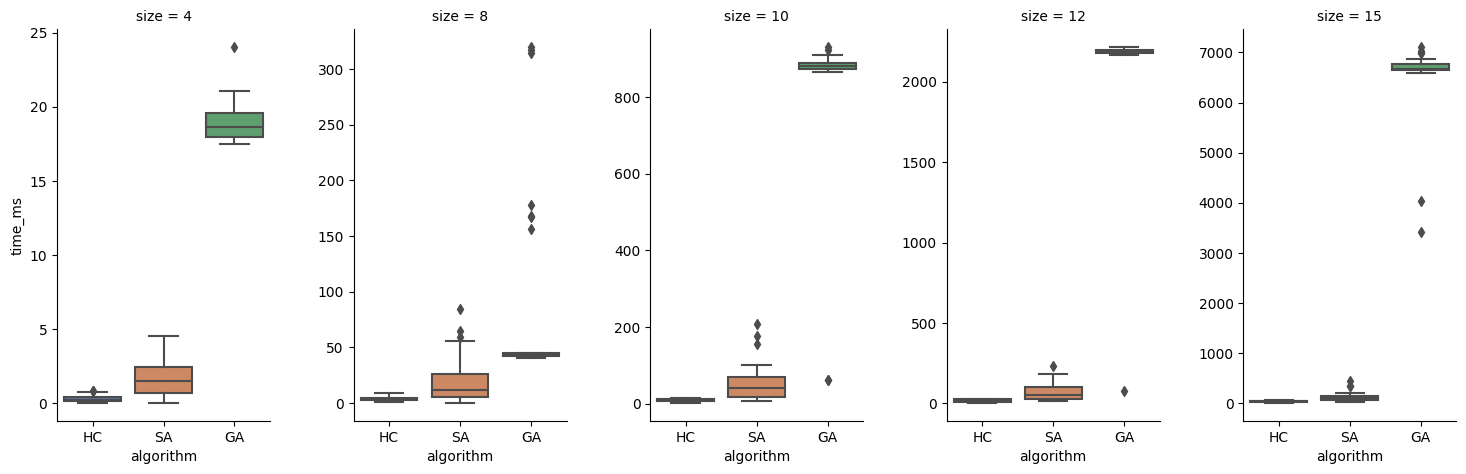

In [6]:
%matplotlib inline

grid1 = sns.FacetGrid(data=simulations_df, col='size', sharey=False)
grid1.map(sns.boxplot, 'algorithm', 'time_ms', order= [x.__name__ for x in algorithms], palette="deep")
grid1.set_xticklabels(['HC', 'SA', 'GA'])

grid1.fig.subplots_adjust(top=1.5)
grid1.savefig('time_by_algorithm.svg')

### Boxplot - Mejor h() alcanzado

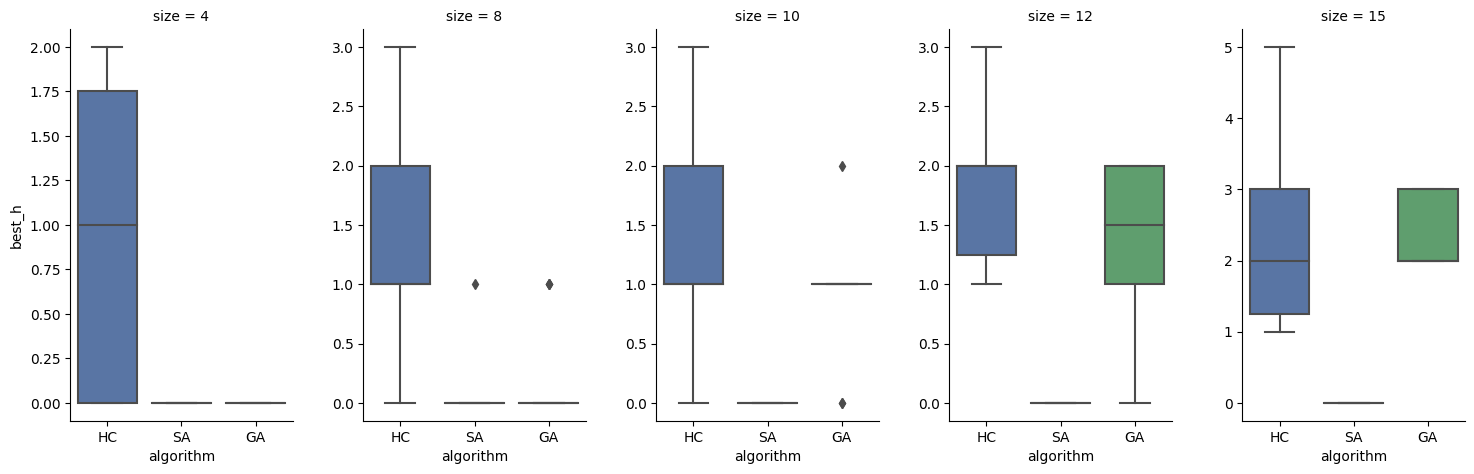

In [7]:
%matplotlib inline

grid2 = sns.FacetGrid(data=simulations_df, col='size', sharey=False)
grid2.map(sns.boxplot, 'algorithm', 'best_h', order= [x.__name__ for x in algorithms], palette="deep")
grid2.set_xticklabels(['HC', 'SA', 'GA'])

grid2.fig.subplots_adjust(top=1.5)
grid2.savefig('h_by_algorithm.svg')


# Comportamiento de h()

## Se llevará acabo con la siguiente configuración

In [8]:
size = 24
n_iterations = 3
limit = 5000

In [9]:
def run_simulation_h(simulations, algorithms, size, limit, i):
    for algorithm in algorithms:
        # Run agent
        _, _, _, h_history = algorithm(size, limit)

        # Dump the data to the simulations list
        for step, h in h_history:
            simulations.append({
                'algorithm': algorithm.__name__,
                'iter': i,
                'step': step,
                'h': h
            })

In [10]:
with mp.Manager() as manager:
    simulations_h = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Run
    for i in range(n_iterations):
        pool.apply_async(run_simulation_h, args=(simulations_h, algorithms, size, limit, i))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a list
    simulations_h_df = pd.DataFrame(list(simulations_h))

### Lineplot - Comportamiento de h() por algorítmo, en tableros idénticos

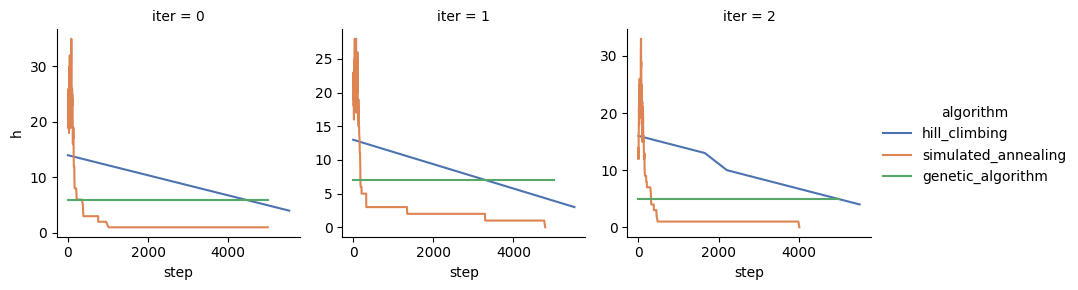

In [11]:
%matplotlib inline

grid3 = sns.FacetGrid(data=simulations_h_df, hue='algorithm', col='iter', sharey=False, palette="deep")
grid3.map(sns.lineplot, 'step', 'h')
grid3.add_legend()

grid3.savefig('h-behavior.svg')